In [2]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set(style='darkgrid', context='talk', palette='Dark2')
my_year_month_fmt = mdates.DateFormatter('%m/%y')


import yfinance as yf
yf.pdr_override() #To import data from Yahoo finance for pandas data frame

# download dataframe using pandas_datareader
data = pdr.get_data_yahoo("SPY", start="2018-01-01", end="2019-09-01")
data.tail()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-26,287.27,288.00,285.58,288.00,286.68,72423800
2019-08-27,289.54,289.95,286.03,286.87,285.55,66668900
2019-08-28,286.14,289.07,285.25,288.89,287.56,59696700
2019-08-29,291.72,293.16,290.61,292.58,291.24,57899400
2019-08-30,294.22,294.24,291.42,292.45,291.11,62901200


In [3]:
# Calculating the shortert period simple moving average
short_rolling = data.rolling(window=20).mean()

# Calculating the longer period simple moving average
long_rolling = data.rolling(window=100).mean()

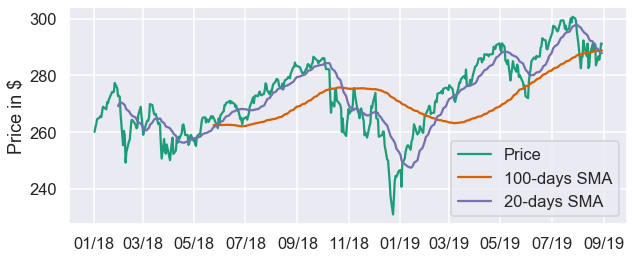

In [4]:
start_date = '2018-01-01'
end_date = '2019-09-01'

fig, ax = plt.subplots(figsize=(10,4))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'Adj Close'], label='Price')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'Adj Close'], label = '100-days SMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'Adj Close'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

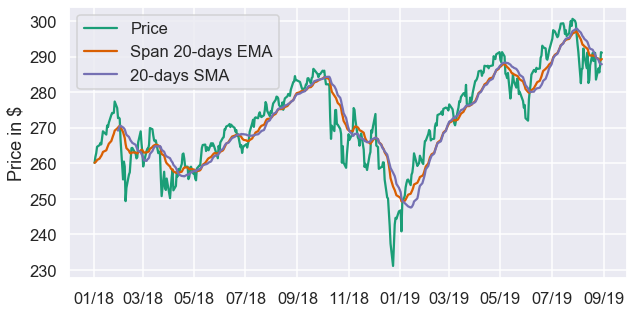

In [5]:
# Using Pandas to calculate a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
ema_short = data.ewm(span=20, adjust=False).mean()

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'Adj Close'], label='Price')
ax.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'Adj Close'], label = 'Span 20-days EMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'Adj Close'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)
data['EMA'] = ema_short.loc[start_date:end_date, 'Adj Close'] #exporting ema data to dataframe

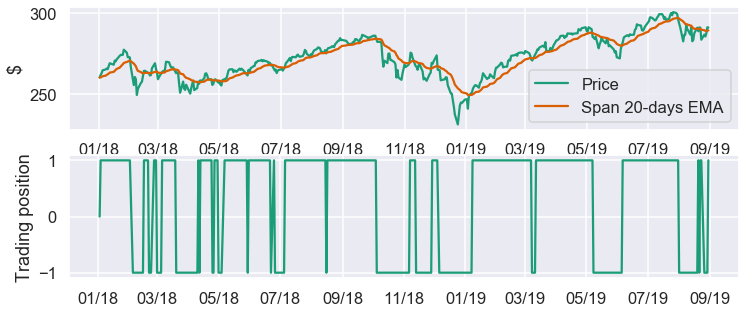

In [6]:
# Taking the difference between the prices and the EMA timeseries
trading_positions_raw = data - ema_short

# Taking the sign of the difference to determine whether the price or the EMA is greater
trading_positions = trading_positions_raw.apply(np.sign)

# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,5))

ax1.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date,'Adj Close'], label='Price')
ax1.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'Adj Close'], label = 'Span 20-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date,'Adj Close'], label='Trading position')

ax2.set_ylabel('Trading position')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [7]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
asset_log_returns = np.log(data).diff()

strategy_asset_log_returns = trading_positions_final * asset_log_returns

# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

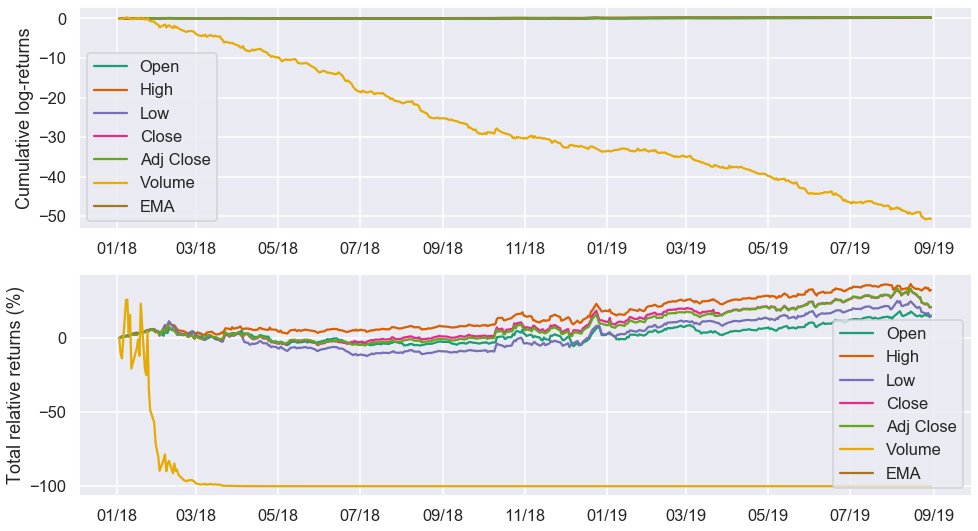

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns:
    ax1.plot(cum_strategy_asset_log_returns.index, cum_strategy_asset_log_returns[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

for c in asset_log_returns:
    ax2.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns[c], label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

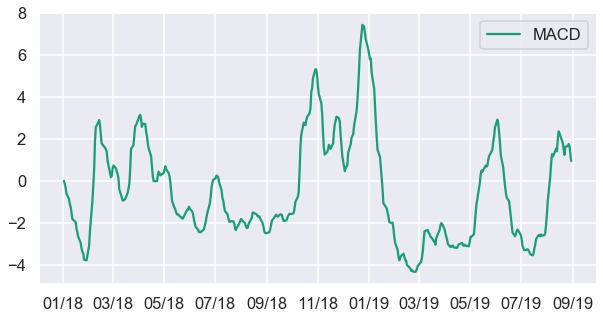

In [9]:
#With MACD
# Subtract the 26 Day EMA from the 12 Day EMA, arriving at the MACD
ema_12= data.ewm(span=12, adjust=False).mean()
ema_26 = data.ewm(span=26, adjust=False).mean()

MACD = ema_26 - ema_12

fig, ax = plt.subplots(figsize=(10,5))


ax.plot(MACD.loc[start_date:end_date, :].index, MACD.loc[start_date:end_date, 'Adj Close'], label = 'MACD')

ax.legend(loc='best')

ax.xaxis.set_major_formatter(my_year_month_fmt)
data['MACD'] = MACD.loc[start_date:end_date,'Adj Close'] #exporting MACD data to dataframe

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


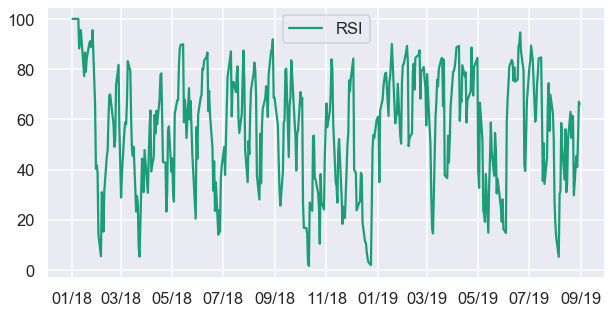

In [10]:
#With RSI
def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

data['RSI'] = rsiFunc(data['Adj Close'],n=4) #exporting RSI data to dataframe

fig, ax = plt.subplots(figsize=(10,5))


ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'RSI'], label = 'RSI')

ax.legend(loc='best')

ax.xaxis.set_major_formatter(my_year_month_fmt)

In [11]:
data.tail() # To check whether data is in format or not.
#Result shows it is still in format, now we will feature selection process

,Open,High,Low,Close,Adj Close,Volume,EMA,MACD,RSI
Date,,,,,,,,,
2019-08-26,287.27,288.00,285.58,288.00,286.68,72423800,289.416142,1.656848,45.382895
2019-08-27,289.54,289.95,286.03,286.87,285.55,66668900,289.047938,1.754724,41.000226
2019-08-28,286.14,289.07,285.25,288.89,287.56,59696700,288.906229,1.651069,51.995062
2019-08-29,291.72,293.16,290.61,292.58,291.24,57899400,289.128493,1.257481,67.004956
2019-08-30,294.22,294.24,291.42,292.45,291.11,62901200,289.317208,0.945154,66.032469


In [12]:
# Let's implement PCA algorithm on our variables data calculated above

num_pc = 2

X = np.asarray(data)
[n,m] = X.shape
print ('The number of timestamps are '+ format(n))
print ('The number of explanatory variables are ' + format(m))

pca = PCA(n_components=num_pc) # number of principal components
pca.fit(X)

percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print (format(percentage_cum[-1]*100) + ' of the variance is explained by the first 2 PCs')

pca_components = pca.components_

The number of timestamps are 419
The number of explanatory variables are 9
99.99999999997804 of the variance is explained by the first 2 PCs


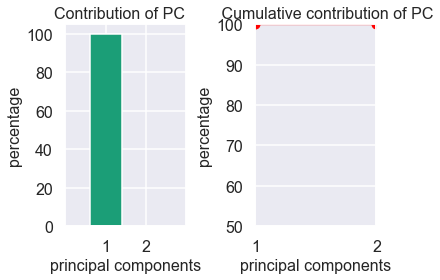

In [20]:
#Now we collect the first two principal components and plot their contributions.
x = np.arange(1,len(percentage)+1,1)
#PC is principal components
plt.subplot(1, 2, 1)
plt.bar(x, percentage*100, align = "center")
plt.title('Contribution of PC   ',fontsize = 16)
plt.xlabel('principal components',fontsize = 16)
plt.ylabel('percentage',fontsize = 16)
plt.xticks(x,fontsize = 16) 
plt.yticks(fontsize = 16)
plt.xlim([0, num_pc+1])

plt.subplot(1, 2, 2)
plt.plot(x, percentage_cum*100,'ro-')
plt.xlabel('principal components',fontsize = 16)
plt.ylabel('percentage',fontsize = 16)
plt.title('     Cumulative contribution of PC',fontsize = 16)
plt.xticks(x,fontsize = 16) 
plt.yticks(fontsize = 16)
plt.xlim([1, num_pc])
plt.ylim([50,100]);
plt.tight_layout()

In [23]:
#constructing "statistical risk factors" from principal component calculated above
factor_returns = X.dot(pca_components.T)
factor_returns = pd.DataFrame(columns=["factor 1", "factor 2"], index=data.index, data=factor_returns)
factor_returns.head()

,factor 1,factor 2
Date,,
2018-01-02,8.665570e+07,657.229347
2018-01-03,9.007040e+07,661.410188
2018-01-04,8.063640e+07,661.873259
2018-01-05,8.352400e+07,665.943853
2018-01-08,5.731920e+07,660.039017


In [24]:
#calculatinmg factor returns which are are an analogue to the principal component matrix
factor_exposures = pd.DataFrame(index=["factor 1", "factor 2"], columns=data.columns, data = pca.components_).T
factor_exposures

,factor 1,factor 2
Open,-1.309558e-07,3.999357e-01
High,-1.183555e-07,3.926041e-01
Low,-1.589775e-07,3.909061e-01
Close,-1.435452e-07,3.857324e-01
Adj Close,-1.528739e-07,4.301545e-01
Volume,1.000000e+00,2.832728e-07
EMA,-7.501454e-08,4.293610e-01
MACD,2.842110e-08,-3.321139e-02
RSI,-2.720672e-07,-1.175992e-01


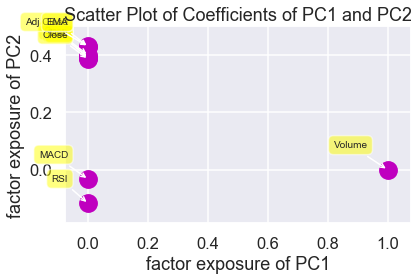

In [25]:
labels = factor_exposures.index
data = factor_exposures.values
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, 0], data[:, 1], marker='o', s=300, c='m',
    cmap=plt.get_cmap('Spectral'))
plt.title('Scatter Plot of Coefficients of PC1 and PC2')
plt.xlabel('factor exposure of PC1')
plt.ylabel('factor exposure of PC2')

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    );
plt.tight_layout()